### Two transmon optimisation
Two coupled transmons with five energy levels each. Both store two qubits. The generation creates a superposition of 2 LOs and envelopes per transmon. This file is used for optimising entangling gates between the transmons.

In [1]:
import argparse
import copy
import os
import sys

# Libs and helpers
from collections import OrderedDict

import numpy as np
import scipy.linalg
import tensorflow as tf

import c3.libraries.algorithms as algorithms
import c3.libraries.envelopes
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.signal.pulse import EnvelopeDrag
from c3.utils.tf_utils import tf_project_to_comp, tf_abs, tf_unitary_overlap
import four_level_transmons.custom_gates as custom_gates
from c3.experiment import Experiment as Exp
# Main C3 objects
from c3.libraries import constants
from c3.model import Model as Mdl
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap as PMap
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.custom_envelopes import *
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *
from four_level_transmons.blackbox import generateSignalFromConfig
from four_level_transmons.notebook_utils import *
from four_level_transmons.input import *

tf.config.run_functions_eagerly(True)
np.set_printoptions(linewidth=300)

2022-12-12 07:29:19.961626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 07:29:19.961648: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
if len(sys.argv[1:]) > 0 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("--output", help="Output directory")
    args = parser.parse_args()
    output_dir = args.output
    print("Output directory: ", output_dir)
else:
    print("=========== WARNING: no output directory specified ============")
    output_dir = "./output"
output = DataOutput(output_dir, file_suffix='before')

=========== WARNING: no output directory specified ============


In [3]:
# general settings
numPWCPieces = 100
usePWC = True
useDRAG = False
t_final = 300e-9
sim_res = 20e9
awg_res = numPWCPieces / t_final if usePWC else 2e9
isDressed = True
useFR = False

ALGORITHM_LBFGS = 0
ALGORITHM_LBFGS_GRAD_FREE = 1
ALGORITHM_CMAES = 2
ALGORITHM_GCMAES = 3
selected_algorithms = [
    #(ALGORITHM_LBFGS, {"maxfun": 50}),
    #(ALGORITHM_CMAES, {}),
    (ALGORITHM_LBFGS, {"maxfun": 1500, "ftol": 5e-6})
]

In [4]:
#IDEAL_GATE, IDEAL_GATE_NAME = np.eye(16), "unity"
#IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_CNOT_t1q2_t2q2, "cnot_t1q2_t2q2"
#IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_iCNOT_t1q2_t2q2, "icnot_t1q2_t2q2"
#IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_iSWAP_t1q2_t2q2, "iswap_t1q2_t2q2"
#IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_SQRTiSWAP_t1q2_t2q2, "sqrtiswap_t1q2_t2q2"
IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_CZ_t1q2_t2q2, "cz_t1_t2"
#IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_UNIVERSAL_ENTANGLER, "universal_entangler"
#IDEAL_GATE, IDEAL_GATE_NAME = custom_gates.GATE_4QUBIT_1110_1111, "cccnot"

OPTIMISE_TFINAL = False
OPTIMISE_FREQUENCIES = True

In [5]:
# coupling=30: f=4.6, anh=-200; f=4.32, anh=-350
# f=4.5: anh=-200, coupling=33
# Initialise the qubits and drive lines
qubit_levels = [5, 5]
qubit_frequencies = [5e9, 4.5e9]
anharmonicities = [-300e6, -250e6]
t1s = [25e-6, 25e-6]
t2stars = [35e-6, 35e-6]
qubit_temps = 50e-3
couplingStrength = 20e6
print("qubits frequencies: ", qubit_frequencies, "anharmonicities: ", anharmonicities,
      "coupling: ", couplingStrength)

level_labels_transmon = ["|0,0\\rangle", "|0,1\\rangle", "|1,0\\rangle", "|1,1\\rangle"]
for i in range(len(level_labels_transmon), max(qubit_levels)):
    level_labels_transmon.append("leakage")
level_labels = []
level_labels_with_leakage = []
level_labels_short = []
for i in range(qubit_levels[0]):
    for j in range(qubit_levels[1]):
        level_labels_short.append(f"{i},{j}")
        if i > 3 or j > 3:
            level_labels_with_leakage.append("leakage")
        else:
            s = f"${level_labels_transmon[i]},{level_labels_transmon[j]}$"
            level_labels.append(s)
            level_labels_with_leakage.append(s)
level_labels_transmon = [f"${x}$" for x in level_labels_transmon]

qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities,
                         t1s, t2stars, qubit_temps)
coupling = createChainCouplings([couplingStrength], qubits)
drives = createDrives(qubits)

qubits frequencies:  [5000000000.0, 4500000000.0] anharmonicities:  [-300000000.0, -250000000.0] coupling:  20000000.0


2022-12-12 07:30:48.871170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-12 07:30:48.871208: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-12 07:30:48.871243: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-12-12 07:30:48.871893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Create the model
model = Mdl(qubits, coupling + drives)
model.set_lindbladian(False)
model.set_dressed(isDressed)
model.set_FR(useFR)

#energies = model.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi)
#print("energies: ", energies)
qubitEnergies = [q.get_Hamiltonian().numpy().diagonal().real / (2 * np.pi) for q in qubits]
qubitEnergies[0] = qubitEnergies[0][::qubit_levels[0]]
qubitEnergies[1] = qubitEnergies[1][:qubit_levels[1]]
qubitTransitions = [np.array([e[i + 1] - e[i] for i in range(len(e) - 1)]) for e in qubitEnergies]
for i in range(len(qubits)):
    print(f"Qubit {i}:")
    print(qubitEnergies[i])
    print(qubitTransitions[i])

Qubit 0:
[0.00e+00 5.00e+09 9.70e+09 1.41e+10 1.82e+10]
[5.0e+09 4.7e+09 4.4e+09 4.1e+09]
Qubit 1:
[0.000e+00 4.500e+09 8.750e+09 1.275e+10 1.650e+10]
[4.50e+09 4.25e+09 4.00e+09 3.75e+09]


In [7]:
spectralData = getSpectralDataFromFile("./optimised_params/fourier basis 5 levels, 300ns/CZ/10.json")
print(spectralData["d1"], spectralData["d2"])
print(spectralData["d1"].amplitudes)

Drive d1: num peaks 10
frequencies d1: 4.574070e+09 4.427495e+09 10
Drive d2: num peaks 10
frequencies d2: 4.488914e+09 4.513830e+09 10
10 frequencies 10 frequencies
[2.99676141 2.30083703 1.78685784 1.59858247 1.49391496 1.23132291 1.12589783 0.67597446 0.54123669 0.32359668]


In [ ]:
#stateEnergies = getEnergiesFromFile('./optimised_params/fourier basis 5 levels/level_energies.npy', level_labels_short)
'''
energiesTransmon = [[0, qubit_frequencies[i], 2 * qubit_frequencies[i] - anharmonicities[i],
                     3 * (qubit_frequencies[i] - anharmonicities[i]), 4 * qubit_frequencies[i] - 6 * anharmonicities[i]] for i in range(2)]
print(energiesTransmon)
stateEnergies = []
for i in range(5):
    for j in range(5):
        stateEnergies.append((energiesTransmon[0][i] + energiesTransmon[1][j], f"{i},{j}"))

transitions = calculateTransitions(stateEnergies)
transitions = sorted(transitions, key=lambda x: x[0])
for x in transitions:
    print(x)
transitionsDict = dict([(x[1],x[0]) for x in transitions])
selectedEnergies = [
    #'0,0 - 1,0', '1,0 - 2,0', '2,0 - 3,0', '3,0 - 4,0',
    #'0,1 - 1,1', '1,1 - 2,1', '2,1 - 3,1', '3,1 - 4,1'
]
for i in range(3):
    for j in range(4):
        selectedEnergies.append(f"{i},{j} - {i+1},{j}")
for i in range(4):
    for j in range(3):
        selectedEnergies.append(f"{i},{j} - {i},{j+1}")
selectedEnergies = [transitionsDict[x] for x in selectedEnergies]
print(selectedEnergies)
selectedEnergiesCNOT = [transitionsDict[x] for x in ['1,0 - 1,1', '1,2 - 1,3', '3,0 - 3,1', '3,2 - 3,3']]
print(selectedEnergiesCNOT)
'''

In [8]:
# Create the generator
'''
cos_frequencies = np.array([4995997406.919341, 4704950761.420654, 4701014384.994876, 5007032274.618064,
                            4062167078.4774194, 4148445305.307898, 4402001629.33434, 4245160832.138902,
                            5000004596.914059, 4715989016.545379, 4377994950.489334, 4691989633.233531,
                            4110695567.278656, 4106672258.1941147])
cos_amplitudes = np.array([0.006776392936855479, 0.006183858694756216, 0.005921233065898419, 0.0053621575456050865,
                           0.0058839116357663175, 0.0041460859937105295, 0.0040101476207611226, 0.003769561777275727,
                           0.003031120830568577, 0.0031130260335161517, 0.002403971046868337, 0.002353206535976198,
                           0.002012669743665184, 0.001825629728895534])
cos_phases = np.array([1.6381027349231951, 2.5838889632467543, -0.6247481636275114, -2.6722366011197876,
                       2.8325504483054322, 1.9886986099203705, 3.1009812892045643, -0.9957720554988438,
                       1.2472118040300213, -1.2076080330207344, -2.911563673846197, -1.4505219481308833,
                       2.4095913176783403, -1.1073120929779088])
'''
generator = createGeneratorNLOs(drives, sim_res=sim_res, awg_res=awg_res, N=len(spectralData["d1"].frequencies))

In [9]:
# Envelopes and carriers
'''
carrier_freqs = [
    #[0.5*(qubitTransitions[0][1]+qubitTransitions[0][0]), 0.5*(qubitTransitions[0][2]+qubitTransitions[0][1])],
    #[qubitTransitions[1][0], qubitTransitions[1][1]],
    [40e6, 563e6],
    #[qubitTransitions[1][0]],
    #[0.5*(qubitTransitions[1][1]+qubitTransitions[1][0]), 0.5*(qubitTransitions[1][2]+qubitTransitions[1][1])],
    #[qubitTransitions[1][0], qubitTransitions[1][1]]
    #[qubitTransitions[1][0]]
    [121e6, 644e6]
]
#df = couplingStrength ** 2 / (qubit_frequencies[0] - qubit_frequencies[1])
#print("shift: ", df)
#carrier_freqs[0] = [x + df for x in carrier_freqs[0]]
#carrier_freqs[1] = [x - df for x in carrier_freqs[1]]

carrier_framechange = [
    [0.01, 0.01],
    [0.01, 0.01]
]
pulse_t_final = [
    [t_final, t_final],
    [t_final, t_final]
]
pulse_sigmas = [
    [t_final/5, t_final/5],
    [t_final/5, t_final/5]
]
pulse_amps = [
    [6, 6],
    [0.1, 0.1]
]
pulse_deltas = [
    [0.01, 0.01],
    [0.01, 0.01]
]
pulse_xy_angles = [
    [0.01, 0.01],
    [0.01, 0.01]
]
pulse_freq_offsets = [
    [0.01, 0.01],
    [0.01, 0.01]
]
'''
'''
carrier_freqs = [[5e9], [4e9]]
pulse_xy_angles = [[1e-6], [1e-6]]
pulse_amps = [[0.001], [0.001]]
carrier_framechange = [[0.0], [0.0]]
pulse_freq_offsets = [[0.0], [0.0]]
pulse_t_final = [[1000e9], [1000e9]]
pulse_sigmas = [[1000e9], [1000e9]]
pulse_deltas = [[0.0], [0.0]]
'''
N = len(spectralData["d1"].frequencies)
numOptimisableEnvs = [N, N]
#carrier_freqs = [selectedEnergiesCNOT, selectedEnergies]
#pulse_xy_angles = [[1e-3] * N, [1e-3] * N]
#pulse_amps = [[1e-8] * N, [1e-8] * N]
#pulse_amps = [[2.0, 1e-8, 1e-8, 1e-8] + [0] * (N - 4), [1e-8] * N]
carrier_framechange = [[1e-8] * N, [1e-8] * N]
pulse_freq_offsets = [[1e-8] * N, [1e-8] * N]
pulse_t_final = [[t_final] * N, [t_final] * N]
pulse_sigmas = [[5 * t_final] * N, [5 * t_final] * N]
pulse_deltas = [[0.0] * N, [0.0] * N]

envelopes = []
envelopesForDrive = {d.name: [] for d in drives}
carriers = []
carriersForDrive = {d.name: [] for d in drives}

# copy carriers and envelopes from file
for idx in []:
    dstIdx = idx
    srcIdx = idx
    driveNameSrc = drives[srcIdx].name
    driveNameDst = drives[dstIdx].name
    stored_params_d = stored_params["drive_channels"][driveNameSrc]
    for i in range(0, len(carrier_freqs[idx])):
        env: pulse.Envelope = copy.deepcopy(stored_params_d[f"envelope_{driveNameSrc}_{i + 1}"])
        if useDRAG and not isinstance(env, EnvelopeDrag):
            env = convertToDRAG(env)
        if usePWC:
            if env.shape != c3.libraries.envelopes.pwc:
                env = convertToPWC(env, numPWCPieces)
            elif len(env.params["inphase"]) != numPWCPieces:
                env = resamplePWC(env, numPWCPieces)
        env.name = f"envelope_{driveNameDst}_{i + 1}"
        #env = scaleGaussianEnvelope(env, t_final / env.params['t_final'].get_value())
        #env.params["amp"] = scaleQuantity(env.params["amp"], 5)
        #if dstIdx==1:
        #    env.params["amp"] = scaleQuantity(env.params["amp"], 0.01)
        envelopes.append(env)
        envelopesForDrive[driveNameDst].append(env)

        #shift = df if dstIdx == 0 else -df
        carrier = copy.deepcopy(stored_params_d[f"carrier_{driveNameSrc}_{i + 1}"])
        #print("Frequency: ", carrier.params["freq"].get_value() / (2 * np.pi),
        #      carrier.params["freq"].get_limits()[0] / (2 * np.pi),
        #      carrier.params["freq"].get_limits()[1] / (2 * np.pi))
        #print(stored_params_d[f"carrier_{driveNameSrc}_{i + 1}"])
        #carrier.params["freq"].set_value(
        #    carrier.params["freq"].get_value() / (2 * np.pi) + shift
        #)
        #carrier.params["freq"] = Qty(
        #    value=carrier_freqs[dstIdx][i],
        #    min_val=0.95 * carrier_freqs[dstIdx][i],
        #    max_val=1.05 * carrier_freqs[dstIdx][i],
        #    unit="Hz 2pi"
        #)
        carrier.name = f"carrier_{driveNameDst}_{i + 1}"
        carriers.append(carrier)
        carriersForDrive[driveNameDst].append(carrier)

# create carriers and envelopes
for idx in [0, 1]:
    data = spectralData[drives[idx].name]
    for i in range(N):
        if i >= len(data.frequencies):
            env = createNoDriveEnvelope(pulse_t_final[idx][i])
        else:
            env = createGaussianPulse(
                t_final=pulse_t_final[idx][i],
                sigma=pulse_sigmas[idx][i],
                amp=data.amplitudes[i],
                delta=pulse_deltas[idx][i],
                xy_angle=data.phases[i],
                freq_off=pulse_freq_offsets[idx][i],
                useDrag=useDRAG
            )
            #env = createNoDriveEnvelope(t_final)
            if usePWC:
                env = convertToPWC(env, numPWCPieces)
        env.name = f"envelope_{drives[idx].name}_{i + 1}"
        #env.params["amp"] = scaleQuantity(env.params["amp"], 0.2)
        envelopes.append(env)
        envelopesForDrive[drives[idx].name].append(env)

        freq = 1e-8 if i >= len(data.frequencies) else data.frequencies[i]
        carrier_parameters = {
            "freq": Qty(value=freq, min_val=0.98 * freq, max_val=1.02 * freq, unit="Hz 2pi"),
            "framechange": Qty(value=carrier_framechange[idx][i], min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
        }
        carrier = pulse.Carrier(
            name=f"carrier_{drives[idx].name}_{i + 1}",
            desc="Frequency of the local oscillator",
            params=carrier_parameters,
        )
        carriers.append(carrier)
        carriersForDrive[drives[idx].name].append(carrier)

print("carrier: ", [[carrier.params["freq"] for carrier in carriers] for carriers in carriersForDrive.values()])
print("amp: ", [[env.params["amp"] for env in envelopes] for envelopes in envelopesForDrive.values()])

carrier:  [[4.574 GHz 2pi, 4.498 GHz 2pi, 4.023 GHz 2pi, 4.004 GHz 2pi, 4.501 GHz 2pi, 3.999 GHz 2pi, 4.493 GHz 2pi, 4.501 GHz 2pi, 4.486 GHz 2pi, 4.427 GHz 2pi], [4.489 GHz 2pi, 4.500 GHz 2pi, 4.506 GHz 2pi, 4.516 GHz 2pi, 4.508 GHz 2pi, 4.484 GHz 2pi, 4.493 GHz 2pi, 4.500 GHz 2pi, 4.001 GHz 2pi, 4.514 GHz 2pi]]
amp:  [[2.997 V, 2.301 V, 1.787 V, 1.599 V, 1.494 V, 1.231 V, 1.126 V, 675.974 mV, 541.237 mV, 323.597 mV], [1.659 V, 1.146 V, 667.876 mV, 574.320 mV, 210.978 mV, 361.694 mV, 261.175 mV, 196.201 mV, 195.061 mV, 118.728 mV]]


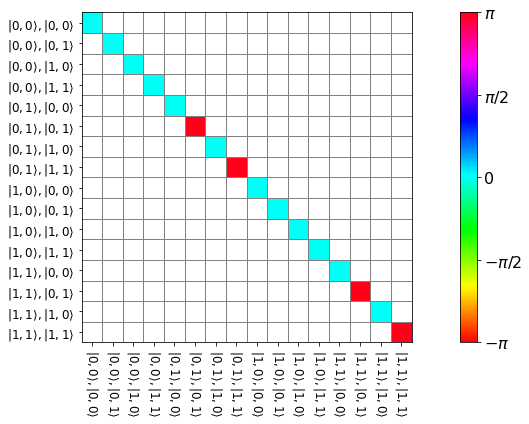

In [10]:
printMatrix(IDEAL_GATE, level_labels, "ideal_gate", output)

gate = gates.Instruction(
    name=IDEAL_GATE_NAME,
    #name="unity",
    targets=[0, 1],
    t_start=0.0,
    t_end=t_final,
    channels=[d.name for d in drives],
    ideal=IDEAL_GATE,
)
for drive in drives:
    for env in envelopesForDrive[drive.name]:
        gate.add_component(copy.deepcopy(env), drive.name)
    for carrier in carriersForDrive[drive.name]:
        gate.add_component(copy.deepcopy(carrier), drive.name)

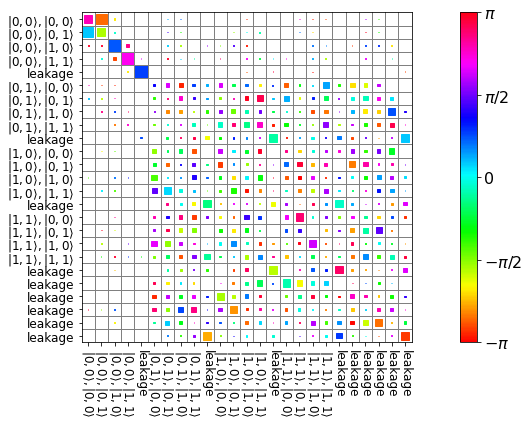

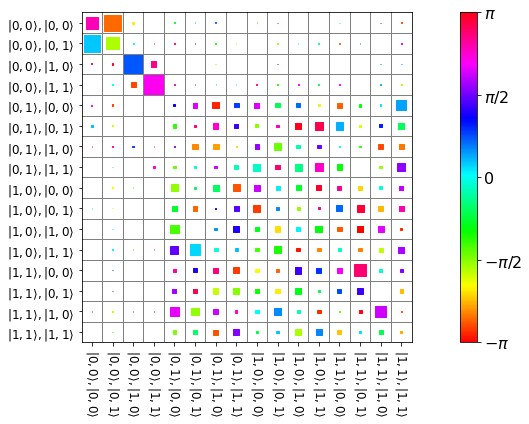

In [11]:
# Set up the experiment
parameter_map = PMap(instructions=[gate], model=model, generator=generator)
exp = Exp(pmap=parameter_map, sim_res=sim_res)
exp.set_opt_gates([gate.get_key()])

unitaries = exp.compute_propagators()
printPropagator(exp, gate, level_labels_with_leakage, level_labels, output)
#printAllSignals(exp, qubit, output, directory="devices_before")
#printSignal(exp, qubits, gate, output=output, states=transitions)
#printMatrix(model.get_Hamiltonian(), level_labels_with_leakage, 'Hamiltonian', output)
#printMatrix(model.get_Hamiltonian() / np.max(model.get_Hamiltonian()), level_labels_with_leakage, 'Hamiltonian_scaled', output)

[(-392328.6650351813, '0,0'), (273976.7836487947, '0,1'), (-119475.37837946806, '0,2'), (-353473.2604569837, '0,3'), (-133834.54138385967, '0,4'), (-182026.23921093854, '1,0'), (-439735.25541038625, '1,1'), (393640.9308331795, '1,2'), (38536.390605076194, '1,3'), (320824.57164660294, '1,4'), (-309537.2661271766, '2,0'), (-85017.83111873541, '2,1'), (-12888.482191013542, '2,2'), (407023.18491446826, '2,3'), (316593.67554719717, '2,4'), (-336658.76296160795, '3,0'), (-214761.37403479914, '3,1'), (-315173.11276738293, '3,2'), (386365.76612974546, '3,3'), (-446064.3429616947, '3,4'), (-454926.7713936328, '4,0'), (-394561.6812296588, '4,1'), (-396412.98023105547, '4,2'), (376304.5797202731, '4,3'), (459739.2323639775, '4,4')]
peaks: d1
	4.553114e+09 (amp=2.490264e+10)
	4.428111e+09 (amp=2.081216e+11)
	4.486112e+09 (amp=4.622271e+11)
	4.493112e+09 (amp=7.428609e+11)
	3.999100e+09 (amp=1.124061e+12)
	4.501113e+09 (amp=1.268054e+12)
	4.004100e+09 (amp=1.339725e+12)
	4.497112e+09 (amp=1.624873e

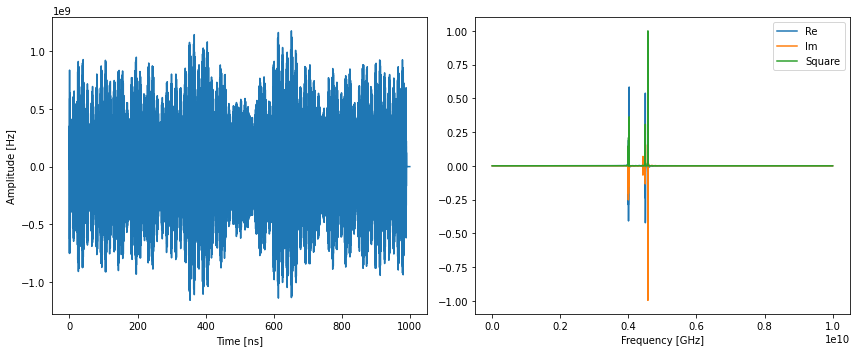

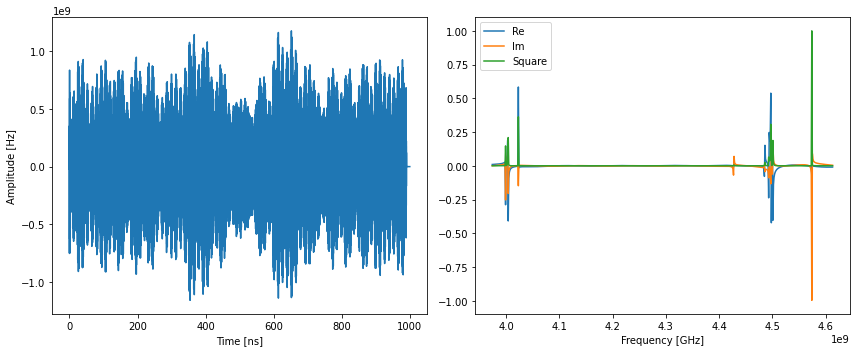

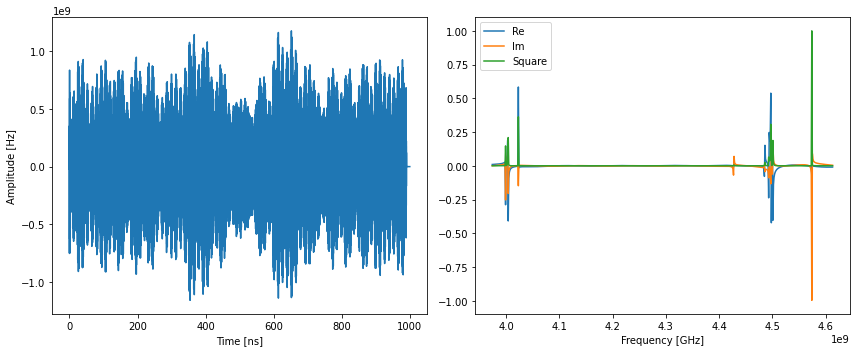

peaks: d2
	4.642116e+09 (amp=3.768232e+09)
	4.361109e+09 (amp=4.415124e+09)
	4.001100e+09 (amp=1.785568e+11)
	4.493112e+09 (amp=1.967688e+11)
	4.508113e+09 (amp=2.035682e+11)
	4.484112e+09 (amp=2.675591e+11)
	4.516113e+09 (amp=3.739609e+11)
	4.506113e+09 (amp=6.672896e+11)
	4.500113e+09 (amp=9.844585e+11)
	4.489112e+09 (amp=1.598270e+12)


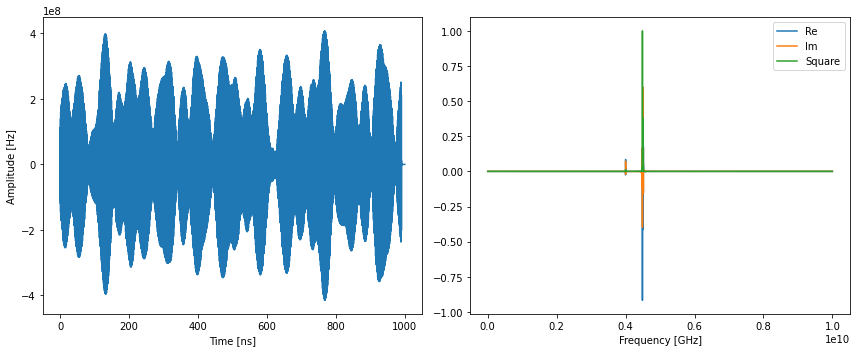

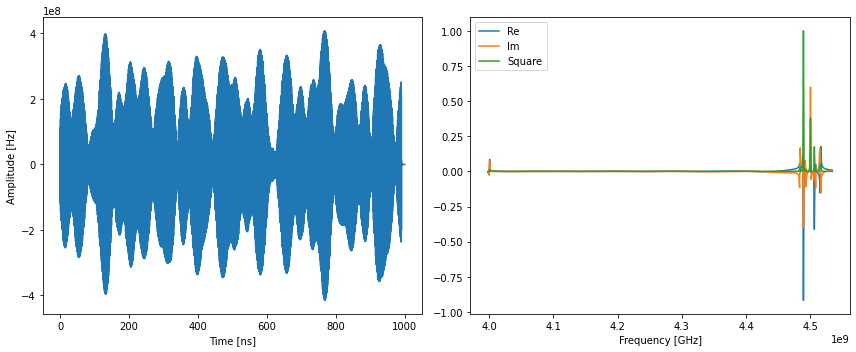

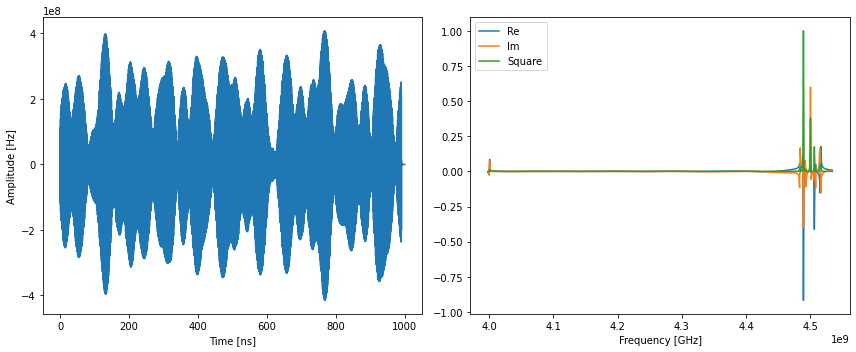

In [12]:
stateEnergies = getEnergiesFromPropagator(unitaries[gate.get_key()], t_final, 1e-12)
print(list(zip(stateEnergies, createTwoTransmonsStateLabels())))

transitions = calculateTransitions(stateEnergies, createTwoTransmonsStateLabels())
printSignal(exp, qubits, gate, output=output, states=transitions)

In [ ]:
# Specify the initial state
'''
psi_init = [[0] * model.tot_dim]
#for i in entanglementInitStateFull:
#    psi_init[0][i] = 1
psi_init[0][0] = 1
psi_init /= np.linalg.norm(psi_init)
print("initial state: ", psi_init)
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = [gate.get_key()]

printTimeEvolution(exp, init_state, gate, level_labels, output)
#printEntanglementEvolution(exp, gate, output)
parameter_map.write_config(output.createFileName("parameter_map", "json"))
'''

In [ ]:
# Specify the parameters to be optimised and initialise the optimiser
opt_map = []
for driveIdx, drive in enumerate(drives):
    for env in envelopesForDrive[drive.name][:numOptimisableEnvs[driveIdx]]:
        opt_map.append([(gate.get_key(), drive.name, env.name, "amp")])
        #opt_map.append([(gate.get_key(), drive.name, env.name, "freq_offset")])
        opt_map.append([(gate.get_key(), drive.name, env.name, "xy_angle")])
        if useDRAG:
            opt_map.append([(gate.get_key(), drive.name, env.name, "delta")])
        if usePWC:
            opt_map.append([(gate.get_key(), drive.name, env.name, "inphase")])
            opt_map.append([(gate.get_key(), drive.name, env.name, "quadrature")])
            #opt_map.append([(gate.get_key(), drive.name, env.name, "t_bin_end")])
        else:
            opt_map.append([(gate.get_key(), drive.name, env.name, "sigma")])
        if OPTIMISE_TFINAL:
            opt_map.append([(gate.get_key(), drive.name, env.name, "t_final")])
    for carrier in carriersForDrive[drive.name]:
        if OPTIMISE_FREQUENCIES:
            opt_map.append([(gate.get_key(), drive.name, carrier.name, "freq")])
    #    #opt_map.append([(gate.get_key(), drive.name, carrier.name, "framechange")])
parameter_map.set_opt_map(opt_map)
parameter_map.print_parameters()

In [ ]:
infidelities = []

for algorithm, params in selected_algorithms:
    if algorithm == ALGORITHM_LBFGS:
        infidelities = optimise(output, qubits, exp, algorithms.lbfgs, {
            "maxfun": 50,
            "ftol": 1e-5,
            **params
        }, gate)
    elif algorithm == ALGORITHM_LBFGS_GRAD_FREE:
        infidelities = optimise(output, qubits, exp, algorithms.lbfgs_grad_free, {
            "maxfun": 1000,
            "gtol": 1e-4,
            "ftol": 1e-4,
            **params
        }, gate)
    elif algorithm == ALGORITHM_CMAES:
        infidelities = optimise(output, qubits, exp, algorithms.cmaes, {
            "popsize": 15,
            "spread": 0.02,
            "maxfevals": 2000,
            "init_point": "True",
            "stop_at_sigma": 1e-3,
            "stop_at_convergence": 20,
            **params
        }, gate)
    elif algorithm == ALGORITHM_GCMAES:
        infidelities = optimise(output, qubits, exp, algorithms.gcmaes, {
            "cmaes": {"popsize": 12, "spread": 0.05, "maxfevals": 20,
                      "init_point": "True", "stop_at_sigma": 1e-4, "stop_at_convergence": 20, **params["cmaes"]},
            "lbfgs": {"maxfun": 500, "ftol": 1e-6, **params["lbfgs"]}
        }, gate)
    else:
        print("Unknown algorithm: ", algorithm)

In [ ]:
# Plot results
output = DataOutput(output_dir, file_suffix='after')
plotData(np.arange(len(infidelities)), infidelities, xlabel="Step",
         ylabel="Infidelity", filename=output.createFileName("convergence", "svg"))
printSignal(exp, qubits, gate, output=output, states=transitions)
#printAllSignals(exp, qubits, output, directory="devices_after")
printPropagator(exp, gate, level_labels_with_leakage, level_labels, output)
#printTimeEvolution(exp, init_state, gate, level_labels, output)
#printEntanglementEvolution(exp, gate, output)
parameter_map.write_config(output.createFileName("parameter_map", "json"))

In [ ]:
'''
import numpy as np
from typing import Tuple
import tensorflow as tf

def makhlinInvariants(U: tf.Tensor) -> tf.Tensor:
    # transform to bell basis
    Q = tf.constant(np.matrix([
        [1, 0, 0, 1j],
        [0, 1j, 1, 0],
        [0, 1j, -1, 0],
        [1, 0, 0, -1j]
    ]) / np.sqrt(2))
    Ub = tf.matmul(tf.linalg.adjoint(Q), tf.matmul(U, Q))

    # calculate characteristics
    m = tf.matmul(tf.transpose(Ub), Ub)
    tr = tf.linalg.trace(m)
    tr2 = tf.linalg.trace(m ** 2)
    trSq = tr ** 2
    g1 = tf.math.real(trSq) / 16.0
    g2 = tf.math.imag(trSq) / 16.0
    g3 = tf.math.real((trSq - tr2)) / 4.0
    return tf.concat([g1, g2, g3], 0)


def makhlinDistance(gs: tf.Tensor) -> tf.Tensor:
    roots = np.roots([1, -g3, 4 * np.sqrt(g1 ** 2 + g2 ** 2) - 1, g3 - 4 * g1]).real()
    roots = np.round(roots, 5)
    z = np.sort(roots)
    print("roots: ", roots)
    print("sorted: ", z)

    d = g3 * np.sqrt(g1 ** 2 + g2 ** 2) - g1
    s = np.pi - np.arccos(z[0]) - np.arccos(z[2])
    print("d: ", d, "s: ", s)
    if d>0 and s>0:
        return d
    elif d<0 and s<0:
        return -d
    else:
        return 0

sqrtSWAP = np.matrix([
    [1, 0, 0, 0],
    [0,(1+1j)/2.0,(1-1j)/2.0,0],
    [0,(1-1j)/2.0,(1+1j)/2.0,0],
    [0,0,0,1],
])
SWAP = np.matrix([
    [1,0,0,0],
    [0,0,1,0],
    [0,1,0,0],
    [0,0,0,1]
])
CNOT = np.matrix([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,0,1],
    [0,0,1,0]
])
UNITY = np.matrix([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0],
    [0, 0, 0, 1]
])
gs = makhlinInvariants(tf.constant(UNITY, dtype=tf.complex128))
print(gs)
#dist = makhlinDistance(g1, g2, g3)
#print(dist)
'''